<a href="https://colab.research.google.com/github/dorasambhrant/Detection-of-Fraud-Transaction/blob/main/Detection_of_Fraud_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [ ]:
df_full = pd.read_csv("/content/Fraud.csv")
df = df_full.copy()
print("Setup complete")

Setup complete


In [ ]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0.0,0.0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0.0,0.0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0.0,0.0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0.0,0.0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0.0,0.0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0.0,0.0


In [ ]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,56203.000000,5.620200e+04,5.620200e+04,5.620200e+04,5.620200e+04,5.620200e+04,56202.000000,56202.0
mean,7.624451,1.598924e+05,7.322726e+05,7.464767e+05,8.391746e+05,1.169835e+06,0.001779,0.0
std,1.999414,3.293750e+05,2.184696e+06,2.222611e+06,2.407619e+06,2.893515e+06,0.042145,0.0
min,1.000000,6.300000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,8.000000,8.135660e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,8.000000,3.623700e+04,1.788471e+04,0.000000e+00,5.114860e+03,2.167320e+03,0.000000,0.0
75%,9.000000,1.918409e+05,1.401448e+05,1.534157e+05,4.722510e+05,8.965790e+05,0.000000,0.0
max,9.000000,1.000000e+07,2.854724e+07,2.861740e+07,3.017978e+07,3.197699e+07,1.000000,0.0


In [ ]:
df.isnull().sum()

step              0
type              0
amount            1
nameOrig          1
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64

In [ ]:
df.shape

(56203, 11)

In [ ]:
# dropping Null or void values

null_index = [] #collecting index of rows that contain any null value
for col in df.columns:
  if(df[col].isnull().any()):
    null_row = df.loc[df[col].isnull()]
    null_index.append(null_row.index)
x = np.array(null_index)
idx = np.unique(x)
print(idx)
df.drop(index = idx,inplace= True)

[56202]


In [ ]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
# Select only numeric columns
numeric_columns = df.select_dtypes(include=['int64','float64'])

# Calculate quantiles for numeric columns
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# The rest of your code to detect outliers should remain the same
def detect_outliers(column):
    lower_bound = Q1[column] - 1.5 * (Q3[column] - Q1[column])
    upper_bound = Q3[column] + 1.5 * (Q3[column] - Q1[column])
    outliers = df.loc[(df[column]<lower_bound) | (df[column]>upper_bound)]
    if outliers.empty:
        return None, 0.0, None
    else:
        percentage = (len(outliers) / len(df)) * 100
        return column, percentage, outliers


for col in numeric_columns:
    column, percentage, outliers = detect_outliers(col)
    print(f"Column: {column}, Percentage of outliers: {percentage:.2f}%")

Column: step, Percentage of outliers: 12.75%
Column: amount, Percentage of outliers: 6.96%
Column: oldbalanceOrg, Percentage of outliers: 18.19%
Column: newbalanceOrig, Percentage of outliers: 17.85%
Column: oldbalanceDest, Percentage of outliers: 15.09%
Column: newbalanceDest, Percentage of outliers: 13.68%
Column: isFraud, Percentage of outliers: 0.18%
Column: None, Percentage of outliers: 0.00%


<Axes: >

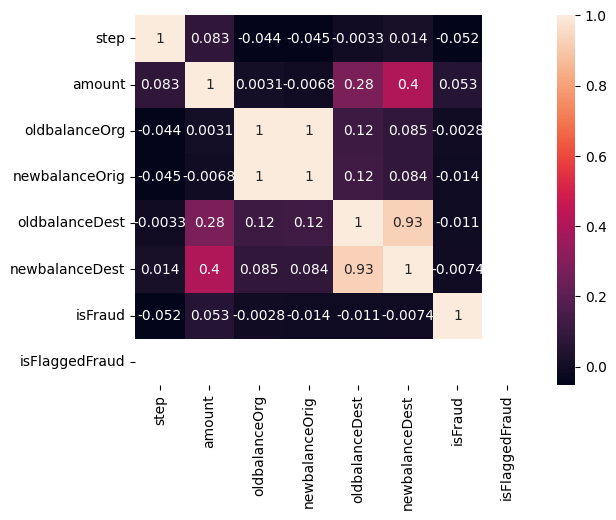

In [ ]:
numerical_columns = df.select_dtypes(exclude = 'object')
sns.heatmap(numerical_columns.corr(),annot=True)

In [ ]:
# due high Multicollinearity we will drop oldbalance data beacuse instead of that columns we can make use of newbalance data
df.drop(columns=['oldbalanceDest', 'oldbalanceOrg'], inplace=True)


In [ ]:
# Checking how many attributes are dtype: object

objList = df.select_dtypes(include = "object").columns
print (objList)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


In [ ]:
#Label Encoding for object to numeric conversion
le = LabelEncoder()

for feat in objList:
    df[feat] = le.fit_transform(df[feat].astype(str))

print (df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56202 entries, 0 to 56201
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            56202 non-null  int64  
 1   type            56202 non-null  int64  
 2   amount          56202 non-null  float64
 3   nameOrig        56202 non-null  int64  
 4   newbalanceOrig  56202 non-null  float64
 5   nameDest        56202 non-null  int64  
 6   newbalanceDest  56202 non-null  float64
 7   isFraud         56202 non-null  float64
 8   isFlaggedFraud  56202 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 3.9 MB
None


In [ ]:
y= df['isFraud']
X = df.drop(['isFraud'],axis=1)

In [ ]:
df.head()

,step,type,amount,nameOrig,newbalanceOrig,nameDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,6560,160296.36,19803,0.0,0.0,0.0
1,1,3,1864.28,19284,19384.72,20581,0.0,0.0,0.0
2,1,4,181.00,8684,0.00,5906,0.0,1.0,0.0
3,1,1,181.00,51509,0.00,5249,0.0,1.0,0.0
4,1,3,11668.14,30304,29885.86,10417,0.0,0.0,0.0


In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X, y = smote.fit_resample(X, y)

In [ ]:
y.value_counts()

isFraud
0.0    56102
1.0    56102
Name: count, dtype: int64

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=142)
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_val.shape)

Shape of X_train:  (78542, 8)
Shape of X_test:  (33662, 8)


In [ ]:
#scaling the data
sc=StandardScaler()
X_train = sc.fit_transform(X_train)
X_val=sc.transform(X_val)

In [ ]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

**Radial** **Support** **Vector** **Machines**(**rbf** **bold text**-**SVM**)

In [ ]:
model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(X_train,y_train)
prediction1=model.predict(X_val)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,y_val))

Accuracy for rbf SVM is  0.9605192799001842


**Linear Support Vector Machine(linear-SVM)**


In [ ]:
model=svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model.fit(X_train,y_train)
prediction2=model.predict(X_val)
print('Accuracy for linear SVM is',metrics.accuracy_score(prediction2,y_val))


Accuracy for linear SVM is 0.8937080387380429


**Logistic Regression**

In [ ]:
model = LogisticRegression()
model.fit(X_train,y_train)
prediction3=model.predict(X_val)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,y_val))


The accuracy of the Logistic Regression is 0.8913314716891451


**Gaussian Naive Bayes**

In [ ]:
model=GaussianNB()
model.fit(X_train,y_train)
prediction4=model.predict(X_val)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction4,y_val))


The accuracy of the NaiveBayes is 0.8184896916404254


**Decision Tree**

In [ ]:
model=DecisionTreeClassifier()
model.fit(X_train,y_train)
prediction5=model.predict(X_val)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction5,y_val))


The accuracy of the Decision Tree is 0.9959895431049849



**Random Forests**

In [ ]:
model=RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)
prediction6=model.predict(X_val)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction6,y_val))


The accuracy of the Random Forests is 0.9979799180084368


In [ ]:
def find_best(n):
  model=RandomForestClassifier(n_estimators=n)
  model.fit(X_train,y_train)
  prediction6=model.predict(X_val)
  print('For estimator = ',n,' the accuracy is : ',metrics.accuracy_score(prediction6,y_val))

for estimator in range(50,250,50):
  find_best(estimator)

For estimator =  50  the accuracy is :  0.9979799180084368
For estimator =  100  the accuracy is :  0.9976828471273246
For estimator =  150  the accuracy is :  0.9979205038322143
For estimator =  200  the accuracy is :  0.997861089655992


**CROSS VALIDATION**

In [ ]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=3) # k=3, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Decision Tree','Random Forest']
models=[DecisionTreeClassifier(),RandomForestClassifier(n_estimators=50)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)
new_models_dataframe2


,CV Mean,Std
Decision Tree,0.684919,0.439127
Random Forest,0.793335,0.290718


In [ ]:
y_pred_randomforest = cross_val_predict(RandomForestClassifier(n_estimators=50),X,y,cv=5)
y_pred_decisiontree = cross_val_predict(DecisionTreeClassifier(),X,y,cv=5)

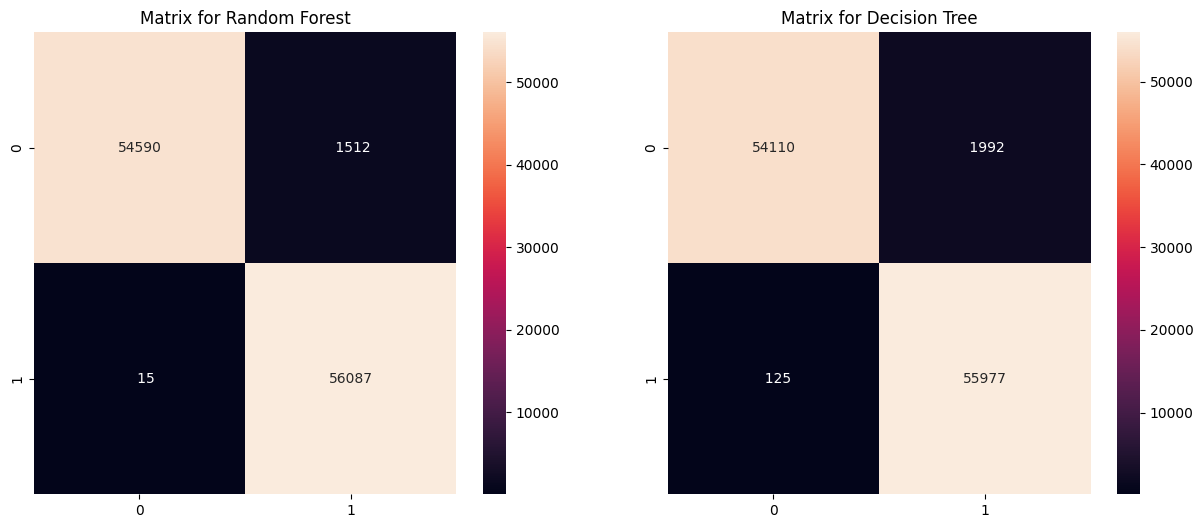

In [ ]:

figure, axis = plt.subplots(1,2,figsize=(15,6))
ax1,ax2 = axis

sns.heatmap(confusion_matrix(y,y_pred_randomforest),ax=ax1,annot=True,fmt='5.0f')
ax1.set_title('Matrix for Random Forest')

sns.heatmap(confusion_matrix(y,y_pred_decisiontree),ax=ax2,annot=True,fmt='5.0f')
ax2.set_title('Matrix for Decision Tree')

plt.show()

In [ ]:
# classification report - Random Forest

classification_report_randomforest = classification_report(y,y_pred_randomforest)
print("Classification Report - Random Forest")
print(classification_report_randomforest)

print("----------------------------------------------------------------------------------------")

# classification report - Decision Tree

classification_report_decisiontree = classification_report(y, y_pred_decisiontree)
print("Classification Report - Decision Tree")
print(classification_report_decisiontree)

Classification Report - Random Forest
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     56102
         1.0       0.97      1.00      0.99     56102

    accuracy                           0.99    112204
   macro avg       0.99      0.99      0.99    112204
weighted avg       0.99      0.99      0.99    112204

----------------------------------------------------------------------------------------
Classification Report - Decision Tree
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     56102
         1.0       0.97      1.00      0.98     56102

    accuracy                           0.98    112204
   macro avg       0.98      0.98      0.98    112204
weighted avg       0.98      0.98      0.98    112204



**Conclusion**





We have seen that Accuracy of Random Forest is slightly better than Decision Tree and both their precision is same. In a fraud detection model, Precision is highly important because rather than predicting normal transactions correctly we want Fraud transactions to be predicted correctly and Legit to be left off.If either of the 2 reasons are not fulfiiled we may catch the innocent and leave the culprit.
This is also one of the reason why Random Forest and Decision Tree are used unstead of other algorithms.

Also the highly unbalanced data favours the use of these models.







---







**5. What are the key factors that predict fraudulent customer?**

The key factors we identified are that type_PAYMENT, type_CASH_IN, type_CASH_OUT , amount and newbalanceOrig are playing major role to know is transaction is Fraud or not The fraud amount happen in very less time within 2 step

*   Validation mechanism for predicted outcomes and Monitoring prediction outcomes.
*   Transaction history of vendors.

---




 **6. Do these factors make sense?** **If yes, How? If not, How not?**

 The factors I took definitly makes sense because I took care of preprocessing step such as null values, duplicates, multicollinearity, encoding, scaling,smote, cross validation , and etc.



---




**7. What kind of prevention should be adopted while company update its** **infrastructure?**



1. Have a fraud monitoring system incorporated into your online banking system.
2. Browse through secured websites.
3. Use secured internet connections (USE VPN).
4. Keep your systems updated and use malware softwares.

In data there was two column ifFraud and isFlaggedFraud, in isFlaggedFraud it was about illegeal attempt so whether it is greater than 200.000 or smaller it doesn't matter fraud will consider fraud instead of two column we can consider isFraud only



---





 **8. Assuming these actions have been implemented, how would you determine if they** **work**?

 This implementation will save time ,prevent to consume more storage in future !


---


